In [2]:
import os, glob, pandas as pd, numpy as np, pyedflib, pickle
from matplotlib import pyplot as plt
from scipy.signal import butter, filtfilt, resample_poly
from scipy.signal import iirnotch, filtfilt
from scipy.signal import find_peaks
from multiprocessing import Pool, cpu_count
from config.config import DataConfig

In [5]:
data_dir = DataConfig.BASE_PATH
subject_dirs = sorted([d for d in os.listdir(data_dir)
                       if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

In [3]:
# # this one just selects the time indices
# k = 10  # total samples per subject

# selected_epochs = {}  # store selected time indices per subject

# for subject in subject_dirs:
#     subject_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subject_path, "*.csv"))
#     if not csv_files:
#         print(f"Skipping {subject}: no CSV found.")
#         continue
#     df = pd.read_csv(csv_files[0], index_col=0)
#     # Filter epochs for wake (W) and sleep (N1)
#     df_W = df[df["stage"] == "W"]
#     df_N1 = df[df["stage"] == "N1"]
#     if len(df_W) < k//2 or len(df_N1) < k//2:
#         print(f"Skipping {subject}: insufficient epochs in one of the classes.")
#         continue
#     sample_W = df_W.sample(n=k//2, random_state=0)["time_index"].tolist()
#     sample_N1 = df_N1.sample(n=k//2, random_state=0)["time_index"].tolist()
#     selected_epochs[subject] = {"W": sample_W, "N1": sample_N1}

# print(selected_epochs)

In [4]:
# # this one actually creates the windows - 10 per electrode in each subject, so this gives 29x930 20-second windows in total (each "centered" in time about the label's index)
# # my computer hates me so shorteniing

# data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])
# # k = 10  # total windows per electrode per subject (5 for W, 5 for N1)
# k = 2 # kernel crashed
# n_per_stage = k // 2
# # window_sec = 20
# window_sec = 4 # +-2 sec on each side
# half_window_sec = window_sec / 2

# windows_dict = {}

# for subject in subject_dirs:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[0], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values

#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     for i, ch_label in enumerate(channel_labels):
#         for stage, sample_times in zip(["W", "N1"], [sample_W, sample_N1]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 windows_dict[key] = win

# # print first 10 keys and their window shapes
# for key in list(windows_dict.keys())[:10]:
#     print(key, windows_dict[key].shape)

In [6]:
def notch_filter(data, fs, freq=60, Q=30):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, data)

def lowpass_filter(data, fs, cutoff=90, order=4):
    nyq = fs/2.0
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def downsample_window(data, fs, target_fs=200):
    return resample_poly(data, target_fs, fs)

In [6]:
# # LP -> downsample (keep up to 100 Hz), then construct windows

# data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])
# k = 2  # total windows per electrode per subject (k/2 for W, k/2 for N1)
# n_per_stage = k // 2
# window_sec = 2   # window spans 2 seconds (±1 sec)
# half_window_sec = window_sec / 2

# windows_dict = {}

# for subject in subject_dirs:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[0], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values

#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)  # original fs, e.g. 1000 Hz
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     for i, ch_label in enumerate(channel_labels):
#         for stage, sample_times in zip(["W", "N1"], [sample_W, sample_N1]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 # Apply lowpass filter and downsample window
#                 filtered_win = lowpass_filter(win, fs, cutoff=90, order=4)
#                 ds_win = downsample_window(filtered_win, fs, target_fs=200)
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 windows_dict[key] = ds_win

# for key in list(windows_dict.keys())[:10]:
#     print(key, windows_dict[key].shape)

POWER LINE AND PREPROCESSING

Identified power line noise frequency: 60.00 Hz


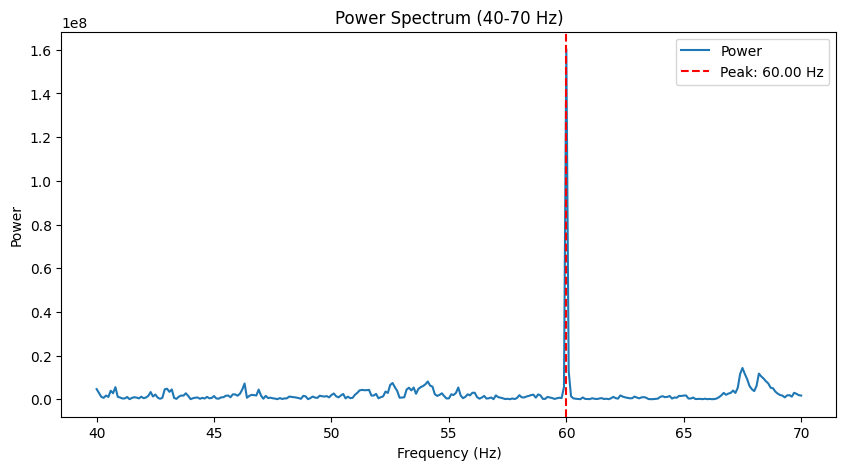

In [7]:
data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"
subject_dirs = sorted([d for d in os.listdir(data_dir)
                       if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])
subject1_path = os.path.join(data_dir, subject_dirs[0])
edf_files = glob.glob(os.path.join(subject1_path, "*.edf"))

if not edf_files:
    print("No EDF file found in:", subject1_path)
else:
    edf_file = edf_files[0]
    reader = pyedflib.EdfReader(edf_file)
    fs = reader.getSampleFrequency(0)
    signal = reader.readSignal(0)  # first channel
    reader.close()
    
    # Extract a 10-second segment starting at 30 seconds
    start_sec = 30
    duration_sec = 10
    start_idx = int(start_sec * fs)
    end_idx = int((start_sec + duration_sec) * fs)
    segment = signal[start_idx:end_idx]
    
    # Compute FFT and corresponding frequencies
    N = len(segment)
    fft_vals = np.fft.rfft(segment)
    fft_freqs = np.fft.rfftfreq(N, 1/fs)
    power = np.abs(fft_vals)**2
    
    # Restrict to 40-70 Hz to identify power-line noise
    mask = (fft_freqs >= 40) & (fft_freqs <= 70)
    freqs_range = fft_freqs[mask]
    power_range = power[mask]
    
    # Identify peak frequency in the range
    peak_idx = np.argmax(power_range)
    peak_freq = freqs_range[peak_idx]
    print(f"Identified power line noise frequency: {peak_freq:.2f} Hz")
    
    # Plot power spectrum for diagnostic
    plt.figure(figsize=(10, 5))
    plt.plot(freqs_range, power_range, label="Power")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Power Spectrum (40-70 Hz)")
    plt.axvline(peak_freq, color='red', linestyle='--', label=f"Peak: {peak_freq:.2f} Hz")
    plt.legend()
    plt.show()

In [8]:
# # first three electrodes for subj 1
# data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# k = 2  # windows per electrode per subject (k/2 for W, k/2 for N1)
# n_per_stage = k // 2
# window_sec = 2   # window spans 2 sec (±1 sec)
# half_window_sec = window_sec / 2

# # Process first 10 subjects
# # for subject in subject_dirs[:10]:
# for subject in subject_dirs[:1]:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[0], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values

#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)  # original fs, e.g. 1000 Hz
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     subject_windows = {}
#     # for i, ch_label in enumerate(channel_labels):
#     for i, ch_label in enumerate(channel_labels[:3]):  
#         for stage, sample_times in zip(["W", "N1"], [sample_W, sample_N1]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 # Apply notch filter at 60 Hz
#                 win = notch_filter(win, fs, freq=60, Q=30)
#                 # Apply lowpass filter to preserve frequencies up to ~100 Hz
#                 win = lowpass_filter(win, fs, cutoff=90, order=4)
#                 # Downsample from fs (e.g. 1000 Hz) to target_fs (200 Hz)
#                 ds_win = downsample_window(win, fs, target_fs=200)
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 subject_windows[key] = ds_win

#     # Save windows in the subject's folder
#     out_path = os.path.join(subj_path, "extracted_windows.pkl")
#     with open(out_path, "wb") as f:
#         pickle.dump(subject_windows, f)
#     print(f"Saved {len(subject_windows)} windows for {subject} at {out_path}")

In [9]:
# for subject in subject_dirs[10:20]:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[0], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     n_per_stage = 1  # using k = 2 per electrode as before (k/2 each)
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values

#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     half_window_sec = 1  # window_sec=2 seconds (±1 sec)
#     subject_windows = {}
#     for i, ch_label in enumerate(channel_labels):
#         for stage, sample_times in zip(["W", "N1"], [sample_W, sample_N1]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 win = notch_filter(win, fs, freq=60, Q=30)
#                 win = lowpass_filter(win, fs, cutoff=90, order=4)
#                 ds_win = downsample_window(win, fs, target_fs=200)
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 subject_windows[key] = ds_win

#     out_path = os.path.join(subj_path, "extracted_windows.pkl")
#     with open(out_path, "wb") as f:
#         pickle.dump(subject_windows, f)
#     print(f"Saved {len(subject_windows)} windows for {subject} at {out_path}")

In [10]:
# for subject in subject_dirs[20:]:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[0], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     n_per_stage = 1  # k=2 per electrode (k/2 each)
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values

#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     half_window_sec = 1  # window spans 2 sec (±1 sec)
#     subject_windows = {}
#     for i, ch_label in enumerate(channel_labels):
#         for stage, sample_times in zip(["W", "N1"], [sample_W, sample_N1]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 win = notch_filter(win, fs, freq=60, Q=30)
#                 win = lowpass_filter(win, fs, cutoff=90, order=4)
#                 ds_win = downsample_window(win, fs, target_fs=200)
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 subject_windows[key] = ds_win

#     out_path = os.path.join(subj_path, "extracted_windows.pkl")
#     with open(out_path, "wb") as f:
#         pickle.dump(subject_windows, f)
#     print(f"Saved {len(subject_windows)} windows for {subject} at {out_path}")

In [11]:
# data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# # Split 93 electrodes into 10 groups
# electrode_indices = np.arange(93)
# electrode_groups = np.array_split(electrode_indices, 10)

# # and one electrode group at a time. Adjust the subject batch size as needed.
# subject_batch = subject_dirs  # You can change to subject_dirs[:3] for example

# k = 2  # windows per electrode per subject (k/2 for W, k/2 for N1)
# n_per_stage = k // 2
# window_sec = 2    # window spans 2 sec (±1 sec)
# half_window_sec = window_sec / 2

# for batch_idx, group in enumerate(electrode_groups):
#     print(f"\nProcessing electrode group {batch_idx+1} (indices {group})")
#     # Loop through the subjects (or a batch of subjects)
#     for subject in subject_batch:
#         subj_path = os.path.join(data_dir, subject)
#         csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#         edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#         if not csv_files or not edf_files:
#             print(f"Skipping {subject}: missing CSV or EDF.")
#             continue
#         df = pd.read_csv(csv_files[0], index_col=0)
#         df_W = df[df["stage"]=="W"]
#         df_N1 = df[df["stage"]=="N1"]
#         if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#             print(f"Skipping {subject}: not enough epochs for one stage.")
#             continue
#         sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#         sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values

#         reader = pyedflib.EdfReader(edf_files[0])
#         fs = reader.getSampleFrequency(0)  # original fs, e.g. 1000 Hz
#         total_samples = reader.getNSamples()[0]
#         n_channels = reader.signals_in_file
#         signals = [reader.readSignal(i) for i in range(n_channels)]
#         channel_labels = reader.getSignalLabels()
#         reader.close()

#         subject_windows = {}
#         # Process only electrodes in the current group
#         for i in group:
#             if i >= len(channel_labels):
#                 continue
#             ch_label = channel_labels[i]
#             for stage, sample_times in zip(["W", "N1"], [sample_W, sample_N1]):
#                 for j, t in enumerate(sample_times):
#                     start = int((t - half_window_sec) * fs)
#                     end = int((t + half_window_sec) * fs)
#                     if start < 0 or end > total_samples:
#                         continue
#                     win = signals[i][start:end]
#                     # Apply notch, lowpass, and downsampling
#                     win = notch_filter(win, fs, freq=60, Q=30)
#                     win = lowpass_filter(win, fs, cutoff=90, order=4)
#                     ds_win = downsample_window(win, fs, target_fs=200)
#                     key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                     subject_windows[key] = ds_win

#         out_path = os.path.join(subj_path, f"extracted_windows_group{batch_idx+1}.pkl")
#         with open(out_path, "wb") as f:
#             pickle.dump(subject_windows, f)
#         print(f"Saved {len(subject_windows)} windows for {subject} in electrode group {batch_idx+1} at {out_path}")
    
#     input(f"\nFinished electrode group {batch_idx+1}. Press Enter to continue to the next group (or restart kernel if desired)...")

GOING IN BATCHES

In [12]:
# # BATCH 1 (FIRST THREE SUBJECTS)
# data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# # Split 93 electrodes into 10 groups and select the first group
# electrode_indices = np.arange(93)
# electrode_groups = np.array_split(electrode_indices, 10)
# first_group = electrode_groups[0]

# # Process only the first 3 subjects; more than one at a time crashes
# # subject_batch = subject_dirs[1:2]
# # subject_batch = subject_dirs[2:3]
# subject_batch = subject_dirs[3:4]

# k = 2  # windows per electrode per subject (k/2 for W, k/2 for N1)
# n_per_stage = k // 2
# window_sec = 2   # window spans 2 sec (±1 sec)
# half_window_sec = window_sec / 2

# for subject in subject_batch:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[0], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values

#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     subject_windows = {}
#     # Process only electrodes in the first group
#     for i in first_group:
#         if i >= len(channel_labels):
#             continue
#         ch_label = channel_labels[i]
#         for stage, sample_times in zip(["W", "N1"], [sample_W, sample_N1]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 win = notch_filter(win, fs, freq=60, Q=30)
#                 win = lowpass_filter(win, fs, cutoff=90, order=4)
#                 ds_win = downsample_window(win, fs, target_fs=200)
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 subject_windows[key] = ds_win

#     out_path = os.path.join(subj_path, "extracted_windows_group1.pkl")
#     with open(out_path, "wb") as f:
#         pickle.dump(subject_windows, f)
#     print(f"Saved {len(subject_windows)} windows for {subject} (electrode group 1) at {out_path}")

In [13]:
# # BATCH 2 (NEXT THREE SUBJECTS)
# data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# total_electrodes = 93
# electrode_indices = np.arange(total_electrodes)
# electrode_groups = np.array_split(electrode_indices, 10)
# print("Electrode Splitting Scheme:")
# for idx, group in enumerate(electrode_groups):
#     count = len(group)
#     proportion = count / total_electrodes
#     print(f"  Group {idx+1}: indices {group}, count = {count}, proportion = {proportion:.2f}")

# # For the second electrode group, process only the first subject from the second batch.
# second_group = electrode_groups[1]
# # Subject 4 is the first subject in the second batch: subject_dirs[3]
# # subject_batch = subject_dirs[3:4]
# # subject_batch = subject_dirs[4:5]
# subject_batch = subject_dirs[5:6]
# # subject_batch = subject_dirs[6:7]

# k = 2  # windows per electrode per subject (k/2 for W, k/2 for N1)
# n_per_stage = k // 2
# window_sec = 2   # window spans 2 sec (±1 sec)
# half_window_sec = window_sec / 2

# for subject in subject_batch:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[0], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values

#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     subject_windows = {}
#     # Process only electrodes in the second group
#     for i in second_group:
#         if i >= len(channel_labels):
#             continue
#         ch_label = channel_labels[i]
#         for stage, sample_times in zip(["W", "N1"], [sample_W, sample_N1]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 win = notch_filter(win, fs, freq=60, Q=30)
#                 win = lowpass_filter(win, fs, cutoff=90, order=4)
#                 ds_win = downsample_window(win, fs, target_fs=200)
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 subject_windows[key] = ds_win

#     out_path = os.path.join(subj_path, "extracted_windows_group2.pkl")
#     with open(out_path, "wb") as f:
#         pickle.dump(subject_windows, f)
#     print(f"Saved {len(subject_windows)} windows for {subject} in electrode group 2 at {out_path}")

In [14]:
# data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])
# # subject_batch = subject_dirs[5:6]
# subject_batch = subject_dirs[6:7]
# for subject in subject_batch:
#     print("Subject folder:", subject)

In [15]:
# subj_path = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data/epctl01"
# pkl_path = os.path.join(subj_path, "extracted_windows_group1.pkl")

# # Load the pickle file
# with open(pkl_path, "rb") as f:
#     windows_dict = pickle.load(f)

# # Print overall structure
# print("Total number of windows saved:", len(windows_dict))
# print("\nSample entries:")
# for key in list(windows_dict.keys())[:5]:
#     print(f"Key: {key}  ->  Window shape: {windows_dict[key].shape}")

In [16]:
# BATCH 3
data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"
subject_dirs = sorted([d for d in os.listdir(data_dir)
                       if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])
total_electrodes = 93
electrode_indices = np.arange(total_electrodes)
electrode_groups = np.array_split(electrode_indices, 10)
print("Electrode Splitting Scheme:")
for idx, group in enumerate(electrode_groups):
    count = len(group)
    proportion = count / total_electrodes
    print(f"  Group {idx+1}: indices {group}, count = {count}, proportion = {proportion:.2f}")

# For Batch 3, select electrode group index 2 (i.e. the third group)
current_group = electrode_groups[2]
# subject_batch = subject_dirs[:3]  # processing first 3 subjects - don't wanna do all at once
subject_batch = subject_dirs[6:7]  # subject 7
# subject_batch = subject_dirs[7:8]  # subject 8
# subject_batch = subject_dirs[8:9]  # subject 9

k = 2  
n_per_stage = k // 2
window_sec = 2  
half_window_sec = window_sec / 2

for subject in subject_batch:
    subj_path = os.path.join(data_dir, subject)
    csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
    edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
    if not csv_files or not edf_files:
        print(f"Skipping {subject}: missing CSV or EDF.")
        continue
    df = pd.read_csv(csv_files[0], index_col=0)
    df_W = df[df["stage"]=="W"]
    df_N1 = df[df["stage"]=="N1"]
    if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
        print(f"Skipping {subject}: not enough epochs for one stage.")
        continue
    sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values

    reader = pyedflib.EdfReader(edf_files[0])
    fs = reader.getSampleFrequency(0)
    total_samples = reader.getNSamples()[0]
    n_channels = reader.signals_in_file
    signals = [reader.readSignal(i) for i in range(n_channels)]
    channel_labels = reader.getSignalLabels()
    reader.close()

    subject_windows = {}
    for i in current_group:
        if i >= len(channel_labels):
            continue
        ch_label = channel_labels[i]
        for stage, sample_times in zip(["W", "N1"], [sample_W, sample_N1]):
            for j, t in enumerate(sample_times):
                start = int((t - half_window_sec) * fs)
                end = int((t + half_window_sec) * fs)
                if start < 0 or end > total_samples:
                    continue
                win = signals[i][start:end]
                win = notch_filter(win, fs, freq=60, Q=30)
                win = lowpass_filter(win, fs, cutoff=90, order=4)
                ds_win = downsample_window(win, fs, target_fs=200)
                key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
                subject_windows[key] = ds_win

    out_path = os.path.join(subj_path, "extracted_windows_group3.pkl")
    with open(out_path, "wb") as f:
        pickle.dump(subject_windows, f)
    print(f"Saved {len(subject_windows)} windows for {subject} in electrode group 3 at {out_path}")

Electrode Splitting Scheme:
  Group 1: indices [0 1 2 3 4 5 6 7 8 9], count = 10, proportion = 0.11
  Group 2: indices [10 11 12 13 14 15 16 17 18 19], count = 10, proportion = 0.11
  Group 3: indices [20 21 22 23 24 25 26 27 28 29], count = 10, proportion = 0.11
  Group 4: indices [30 31 32 33 34 35 36 37 38], count = 9, proportion = 0.10
  Group 5: indices [39 40 41 42 43 44 45 46 47], count = 9, proportion = 0.10
  Group 6: indices [48 49 50 51 52 53 54 55 56], count = 9, proportion = 0.10
  Group 7: indices [57 58 59 60 61 62 63 64 65], count = 9, proportion = 0.10
  Group 8: indices [66 67 68 69 70 71 72 73 74], count = 9, proportion = 0.10
  Group 9: indices [75 76 77 78 79 80 81 82 83], count = 9, proportion = 0.10
  Group 10: indices [84 85 86 87 88 89 90 91 92], count = 9, proportion = 0.10


KeyboardInterrupt: 

In [17]:
# import os, glob, pickle, numpy as np, pandas as pd, pyedflib
# from scipy.signal import butter, filtfilt, resample_poly, iirnotch

# def notch_filter(data, fs, freq=60, Q=30):
#     b, a = iirnotch(freq, Q, fs)
#     return filtfilt(b, a, data)

# def lowpass_filter(data, fs, cutoff=90, order=4):
#     nyq = fs/2.0
#     normal_cutoff = cutoff/nyq
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     return filtfilt(b, a, data)

# def downsample_window(data, fs, target_fs=200):
#     return resample_poly(data, target_fs, fs)

# data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"
# subject_dirs = sorted([d for d in os.listdir(data_dir) 
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])
# total_electrodes = 93
# electrode_indices = np.arange(total_electrodes)
# electrode_groups = np.array_split(electrode_indices, 10)
# print("Electrode Splitting Scheme:")
# for idx, group in enumerate(electrode_groups):
#     count = len(group)
#     proportion = count / total_electrodes
#     print(f"  Group {idx+1}: indices {group}, count = {count}, proportion = {proportion:.2f}")

# # For Batch 4, select electrode group index 3 (i.e. the 4th group)
# current_group = electrode_groups[3]
# subject_batch = subject_dirs[3:4]

# k = 2  # windows per electrode per subject (k/2 for W and k/2 for N1)
# n_per_stage = k // 2
# window_sec = 2  # total window duration (2 sec, i.e. ±1 sec)
# half_window_sec = window_sec / 2

# for subject in subject_batch:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[0], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values

#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)  # original sampling rate (e.g. 1000 Hz)
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     subject_windows = {}
#     for i in current_group:
#         if i >= len(channel_labels):
#             continue
#         ch_label = channel_labels[i]
#         for stage, sample_times in zip(["W", "N1"], [sample_W, sample_N1]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 # Apply filtering pipeline:
#                 # 1. Notch filter at 60 Hz (remove power-line noise)
#                 win = notch_filter(win, fs, freq=60, Q=30)
#                 # 2. Lowpass filter with cutoff at 90 Hz (preserve frequencies below ~90 Hz)
#                 win = lowpass_filter(win, fs, cutoff=90, order=4)
#                 # 3. Downsample from fs (e.g. 1000 Hz) to 200 Hz (new sampling rate)
#                 ds_win = downsample_window(win, fs, target_fs=200)
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 subject_windows[key] = ds_win

#     out_path = os.path.join(subj_path, "extracted_windows_group4.pkl")
#     with open(out_path, "wb") as f:
#         pickle.dump(subject_windows, f)
#     print(f"Saved {len(subject_windows)} windows for {subject} in electrode group 4 at {out_path}")